In [1]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import pandas as pd
import os
import re
import json
import codecs
import folium
from scipy import sparse, stats, spatial
import scipy.sparse.linalg
import requests
%matplotlib inline


### Load election data

We parsed the data from the website of the federal office for statistics into xls files. We load the data into pandas dataset and transform them into numpy arrays. We also checked the communes that have been merged between 2013 (the date of the topojson) and 2015 and defined a list to handle it later.

In [2]:
def load_party_data(path):
    data=pd.read_excel(path)
    data.drop([data.columns[0],data.columns[2],data.columns[3],data.columns[4]],1,inplace=True)
    data.drop([0,1],0,inplace=True)
    data.columns=['commune','party','percentage']
    data=data.ffill()
    data=data.groupby(['commune','party']).sum().unstack('party')
    data2=data.reset_index()['percentage']
    data2['commune']=data.reset_index()['commune']
    return data2

In [3]:
#load party data
data=load_party_data('data/partis_12prem_vote_2015.xlsx')
data2=load_party_data('data/partis_12der_vote_2015.xlsx')

#take only commune (not districts)
data=data[data['commune'].str.startswith('......')]
data2=data2[data2['commune'].str.startswith('......')]
data['commune']=data['commune'].str[7:]
data2['commune']=data2['commune'].str[7:]

#merge the two datasets
data=pd.merge(data,data2,on='commune')

#replace non-available parties with 0
data.loc[:, data.columns != 'commune']=data.loc[:, data.columns != 'commune'].replace('...','0')

#remove data coming from correspondancy votes
data=data[(data['commune'].str[:2]==(data['commune'].str.upper()).str[:2]) & (data['commune'].str[2]=='-') ==False]
data.loc[:, data.columns != 'commune']=data.loc[:, data.columns != 'commune']
data=data.set_index('commune')
data.index=data.index.str.replace(re.escape(' (Urne commune)'),'')
data=data.astype(float)
data=data.sort_index()

In [4]:
#load election metadata and rename columns
general=pd.read_excel('data/general_2015.xlsx')
general=general[['Unnamed: 1','Unnamed: 9']]
general.drop([0,1],0,inplace=True)
general.columns=['commune','voters']

#take only the voter per commune (not districts) and remove data coming from correspondancy votes
general=general[general['commune'].str.startswith('......',na=False)]
general['commune']=general['commune'].str[7:]
general=general[(general['commune'].str[:2]==(general['commune'].str.upper()).str[:2]) & (general['commune'].str[2]=='-') ==False]
general['voters']=general['voters'].replace('...','0')
general['voters']=general['voters'].astype(int)
general=general.set_index('commune')
general=general.sort_index()

In [5]:
#prepare data for genetic algorithm
data2=data.drop([col for col, val in data.sum().iteritems() if val==0],axis=1)
data_tot=data2.as_matrix()
data.index.to_series()[data_tot.sum(1)==0]
data_tot=data_tot/100


#remove communes with no votes
commune_with_no_vote=(data_tot.sum(1)==0)
data_tot[commune_with_no_vote,-1]=1
#data_tot[commune_with_no_vote==False]=np.divide(data_tot[commune_with_no_vote==False],data_tot[commune_with_no_vote==False].sum(1)[:,None])
#data_tab=data_tot[commune_with_no_vote==False]
data_tab=data_tot
#data[commune_with_no_vote==False]

In [6]:
#prepare voter data for genetic algorithm
pop_tot=np.squeeze(general.as_matrix())
#pop_tab=pop_tot[commune_with_no_vote==False]
pop_tab=pop_tot
pop_tab[commune_with_no_vote]=1e-3

In [7]:
#We defined here a list of merged communes between 2013 and 2015, with the resulting commune in the first position


fusion=[['Valbirse','Malleray','Bévilard','Pontenet'],
        ['Terre di Pedemonte','Cavigliano','Tegna','Verscio'],
        ['Val-de-Charmey','Charmey','Cerniat (FR)'],
        ['Sauge','Frinvillier','Plagne','Vauffelin'],
        ['Buchegg','Aetigkofen','Aetingen','Bibern (SO)','Brügglen','Gossliwil','Hessigkofen','Küttigkofen','Kyburg-Buchegg','Mühledorf (SO)','Tscheppach'],
        ['Domleschg','Almens','Paspels','Pratval','Rodels','Tomils'],
        ['Petit-Val','Châtelat','Monible','Sornetan','Souboz'],
        ['Ilanz/Glion','Castrisch','Ilanz','Ladir','Luven','Pitasch','Riein','Ruschein','Schnaus','Sevgein','Duvin','Pigniu','Rueun','Siat'],
        ['Péry-La Heutte','Péry','La Heutte'],
        ['Calanca','Arvigo','Braggio','Cauco','Selma'],
        ['Bettmeralp','Betten','Martisberg'],
        ['Arzier-Le Muids','Arzier'],
        ['Schinznach','Schinznach-Dorf','Oberflachs'],
        ['Albula/Alvra','Alvaschein','Mon','Stierva','Tiefencastel','Alvaneu','Brienz/Brinzauls','Surava'],
        ['Bussigny','Bussigny-près-Lausanne'],
        ['Stocken-Höfen','Niederstocken','Oberstocken','Höfen'],
        ['Plateau de Diesse','Diesse','Lamboing','Prêles'],
        ['Mendrisio','Besazio','Ligornetto','Meride'],
        ['Lugano','Bogno','Cadro','Carona','Certara','Cimadera','Sonvico','Valcolla'],
        ['Bauma','Sternenberg'],
        ['Scuol','Guarda','Ardez','Tarasp','Ftan','Sent'],
        ['Jegenstorf','Scheunen','Münchringen'],
        ['Fraubrunnen','Büren zum Hof','Etzelkofen','Grafenried','Limpach','Mülchi','Schalunen','Zauggenried'],
        ['Murten','Staatswald Galm'],
        ['Grafschaft','Kommunanz Reckingen-Gluringen/Grafschaft'],
        ['Cadenazzo','Comunanza Cadenazzo/Monteceneri'],
        ['Wiesendangen','Bertschikon'],
        ['Innertkirchen','Gadmen'],
        ['Endingen','Unterendingen'],
        ['Uttigen','Kienersrüti'],
        ['Bremgarten (AG)','Bremgarten','Hermetschwil-Staffeln'],
        ['Zernez','Lavin','Susch'],
        ['Oberdiessbach','Bleiken bei Oberdiessbach'],
        ['Vals','St. Martin']
]

### Visualize election results

Here, we used folium to visualize the results of the elections.

In [8]:
# read topojson data
json_data_gemeinden = json.load(codecs.open('data/gemeinden.topo.json', 'r', 'utf-8-sig'))
json_data_kantone = json.load(codecs.open('data/kantone.topo.json', 'r', 'utf-8-sig'))

In [9]:
#since the topojson for visualisation dates back to 2013, some old municipipalities in the topojson now unified are
#missing in the dataset. Since it's complicated to find a topojson up to date, we will duplicate the data from the 
#unified municipalities to the old ones.

#list of the old munipalities fron the topjson
with open('data/gemeinden.topo.json') as f:
    muni=json.load(f)
    
s = pd.DataFrame(muni['objects']['gemeinden']['geometries'])
properties=s['properties'].values
municipalities_topo = pd.DataFrame(list(properties))['GMDNAME']
#municipalities_topo

#list of the new municipalities from dataset
#municipalities_data=data['commune']
municipalities_data = pd.Series(data.index.values)
municipalities_data.head()

#diff of both: municipalities in top no it dataset
diff_ind=~municipalities_topo.isin(municipalities_data) 
municipalities_diff= municipalities_topo[diff_ind]

#for all diff munip create new row in data:
#diff_df=pd.DataFrame(columns = data.columns, index= municipalities_diff)
for old_munip in municipalities_diff:
    #find corresponding new munip
    for i in fusion:
        for j in i:
            if old_munip == j:
                new_munip=i[0]
                #copy row from data with corresponding to new munip
                new_row=data.ix[new_munip]
                new_row = pd.DataFrame(new_row.rename(old_munip)).T
                data=data.append(new_row)


/home/samuel/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:32: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated


In [10]:
# display only borders
center_coord = [46.8011111,8.2266667]
m_swiss = folium.Map(location=center_coord,
            tiles='cartodbpositron',           
            zoom_start=7.5)

folium.TopoJson(json_data_gemeinden,'objects.gemeinden',name='communes',style_function=lambda feature: {
        'color': 'blue',
        'fillOpacity':0.0,
        'weight': 2}).add_to(m_swiss)

folium.TopoJson(json_data_kantone,'objects.kantone',name='cantons',style_function=lambda feature: {
        'color': 'red',
        'fillOpacity':0.0,
        'weight': 2}).add_to(m_swiss)
folium.LayerControl().add_to(m_swiss)
m_swiss

Visualise the [map](https://kbacsa.github.io/swiss_border.html).

In [11]:
# choose party to display
party = 'SP/PS'

# get election results for selected party
n_communes = len(json_data_gemeinden['objects']['gemeinden']['geometries'])
party_values = []

for i in range(n_communes):
    json_name = json_data_gemeinden['objects']['gemeinden']['geometries'][i]['properties']['GMDNAME']
    dfval = data[data.index==json_name][party].values.tolist()
    if not dfval:
        dfval=[0]  
    party_values.append([json_name,dfval[0]])
    
labels = ['Name','Score']
party_df = pd.DataFrame(data=party_values,columns=labels)

In [12]:
# build and display folium map of election results
center_coord = [46.8011111,8.2266667]
m_swiss = folium.Map(location=center_coord,
            tiles='cartodbpositron',           
            zoom_start=7.5)

serie = party_df.set_index('Name')['Score']

scale = list(np.linspace(0.,serie.max(),6))

m_swiss.choropleth(geo_data=json_data_gemeinden, topojson='objects.gemeinden', 
    data=serie,
    key_on='feature.properties.GMDNAME',
    threshold_scale=scale,
    fill_color='YlOrRd', fill_opacity=0.6, line_opacity=0.3,
    highlight = True)

folium.TopoJson(json_data_kantone,'objects.kantone',name='cantons',style_function=lambda feature: {
        'color': 'blue',
        'fillOpacity':0.0,
        'weight': 2}).add_to(m_swiss)

m_swiss

Visualise the [map](https://kbacsa.github.io/swiss_votes_SVP_2015.html).

### Spectral clustering
As a preliminary analysis we tried to determine clusters of the most similar commune according to their voting results (each vote results being a vector).

In [13]:
# drop parties with no votes
#data.drop([col for col, val in data.sum().iteritems() if val==0],axis=1)
features = pd.DataFrame(data2)

In order to calculate our distance map, we will use the L1-norm. Similarly to signal processing, the L1-norm enables us to embed a "sharpness" property when partitioning our graph, rather than the L2-norm (euclidean) which has a tendancy to smoothen out divisions instead.

In [14]:
# construct adjacency map based on L1-norm distance map with gaussian kernel
distances = spatial.distance.squareform(spatial.distance.pdist(features,'minkowski', p=1.))
kernel_width = distances.mean()
weights = np.exp(np.divide(-np.square(distances),kernel_width**2))
np.fill_diagonal(weights,0)

In [15]:
def plot(weights, axes):
    axes[0].spy(weights)
    axes[1].hist(weights[weights > 0].reshape(-1), bins=50);

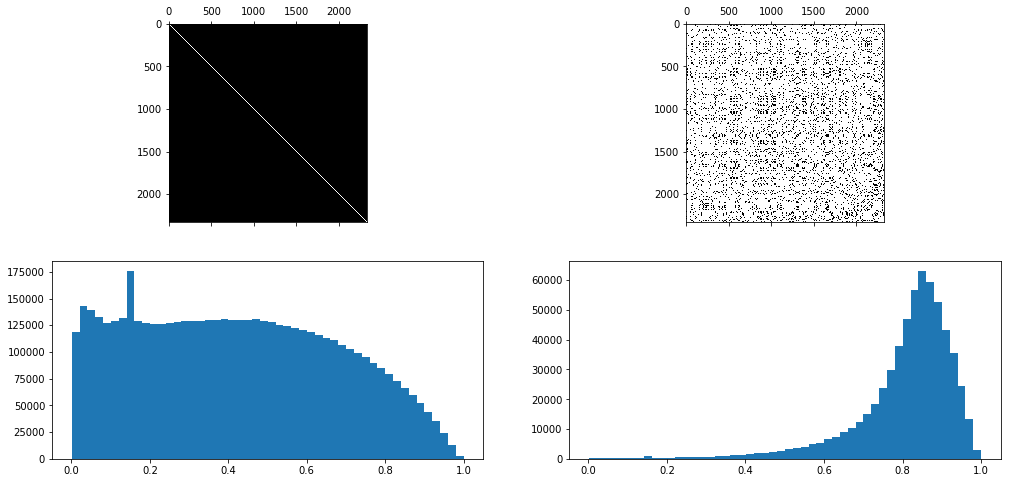

In [16]:
# sparsify weights matrix using nearest neighbors
fix, axes = plt.subplots(2, 2, figsize=(17, 8))
plot(weights, axes[:, 0])

NEIGHBORS = 350

for i in range(weights.shape[0]):
    idx = weights[i,:].argsort()[:-NEIGHBORS]
    weights[i,idx] = 0
    weights[idx,i] = 0

plot(weights, axes[:, 1])

We can see that the weights of our nodes exhibit a power tail distribution. This indicates that our graph is not random, and that it can instead be clustered into different classes. 

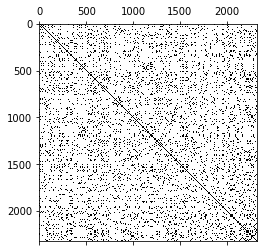

In [17]:
# compute normalized laplacian
degrees = np.sum(weights,axis=0)
laplacian = np.diag(degrees**-0.5) @ (np.diag(degrees) - weights) @ np.diag(degrees**-0.5)
plt.spy(laplacian);
laplacian = sparse.csr_matrix(laplacian)

In [18]:
# calculate eigenvectors (features)
eigenvalues, eigenvectors = sparse.linalg.eigsh(A=laplacian,k=10,which='SM')

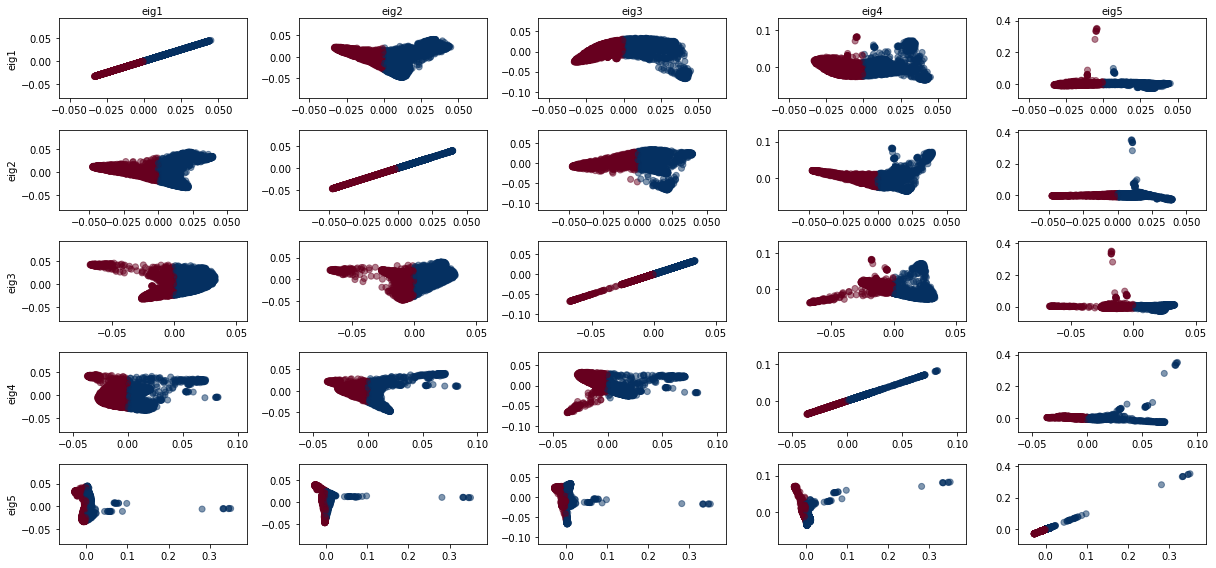

In [19]:
fix, axes = plt.subplots(nrows=5, ncols=5, figsize=(17, 8))
for i in range(1,6):
    for j in range(1,6):
        if i == 1:
            axes[i-1,j-1].set_xlabel('eig' + str(j))
            axes[i-1,j-1].xaxis.set_label_position('top') 
        if j == 1:
            axes[i-1,j-1].set_ylabel('eig' + str(i))
        x = eigenvectors[:,i]
        y = eigenvectors[:,j]
        labels = np.sign(x)
        axes[i-1,j-1].scatter(x, y, c=labels, cmap='RdBu', alpha=0.5)
        
fix.tight_layout()

In [20]:
# define classes and labels
class_1 = (eigenvectors[:,1] >= 0).astype(int)
class_2 = (eigenvectors[:,2] >= 0).astype(int)
class_3 = (eigenvectors[:,3] >= 0).astype(int)
labels = class_1 * 2**2 + class_2 * 2 + class_3
series = pd.Series(labels, index=data2.index.values)

In [21]:
cmap = matplotlib.cm.get_cmap('Spectral')
color_map = cmap(np.arange(0,1,1/26))

In [22]:
def color(class_label, color_map): 
    return  {
    'fillOpacity': 0.5,
    'weight': 0.5,
    'fillColor': '#%02x%02x%02x' % tuple((256 * color_map[class_label,:3]).astype(int)),
    'color': '#%02x%02x%02x' % tuple((256 * color_map[class_label,:3]).astype(int))
     }  

In [23]:
def style_function(data):    
    if data['properties']['GMDNAME'] in series.index:
        class_label = series[series.index == data['properties']['GMDNAME']][0]
        return color(class_label, color_map)
    
    else:
        return  {
        'fillOpacity': 0.5,
        'weight': 0.5,
        'fillColor': '#%02x%02x%02x' % tuple((256 * color_map[0,:3]).astype(int)),
        'color': '#%02x%02x%02x' % tuple((256 * color_map[0,:3]).astype(int))
         } 

In [24]:
def map_cantons(series, json_data_gemeinden, json_data_kantone):
    center_coord = [46.8011111,8.2266667]
    cantons_map = folium.Map(location=center_coord,
                tiles='cartodbpositron',           
                zoom_start=7.5)

    folium.TopoJson(json_data_gemeinden,'objects.gemeinden',name='gemeiden',
                    style_function=style_function).add_to(cantons_map)

    folium.TopoJson(json_data_kantone,'objects.kantone',name='cantons',style_function=lambda feature: {
            'color': 'blue',
            'fillOpacity':0.0,
            'weight': 2}).add_to(cantons_map)
    
    return cantons_map

In [25]:
series.to_csv(path='data/spectral_labels.csv')

In [26]:
# plot classes
center_coord = [46.8011111,8.2266667]
m_swiss = folium.Map(location=center_coord,
            tiles='cartodbpositron',           
            zoom_start=7.5)

scale = list(np.linspace(0.,series.max(),6))

m_swiss.choropleth(geo_data=json_data_gemeinden, topojson='objects.gemeinden', 
    data=series,
    key_on='feature.properties.GMDNAME',
    threshold_scale=scale,
    fill_color='YlOrRd', fill_opacity=0.6, line_opacity=0.3,
    highlight = True)

folium.TopoJson(json_data_kantone,'objects.kantone',name='cantons',style_function=lambda feature: {
        'color': 'blue',
        'fillOpacity':0.0,
        'weight': 2}).add_to(m_swiss)

m_swiss


Visualise the [map](https://kbacsa.github.io/spectral_clustering.html).

### Get graph
In order to have a geographical analysis, we decided to get a graph of the geographical connections between communes (using the json file of 2013).

In [27]:
#url found using Postman
url='http://bl.ocks.org/herrstucki/raw/4327678/aa6f466b7600651bd57838ca70b72ce07e79165d/ch.json'
swiss_dict= requests.get(url).json()


with open('neighbors.json') as f:
    neighbors_index=json.load(f)
#neighbors_index of type list

communes=pd.DataFrame()

municipalities = swiss_dict['objects']['municipalities']['geometries'][:]
municipalities = pd.DataFrame(municipalities)
communes['name'] = pd.DataFrame(list(municipalities['properties'].values))

s = pd.Series(neighbors_index)
neighbors = pd.DataFrame()
neighbors['indexes'] = s
neighbors['municipality'] = communes['name']
neighbors['neighbors'] = neighbors['indexes'].map(lambda x: pd.Series(x).map(neighbors['municipality']).values)
neighbors.to_csv('graph_commune.csv')

### Transform graph

We must also take care of the merged communes in order to update the graph.

/home/samuel/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  # Remove the CWD from sys.path while we load stuff.
/home/samuel/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  app.launch_new_instance()


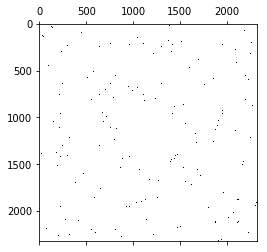

In [28]:
#load the data output from get_neighbors
graph_data=pd.read_csv('graph_commune.csv')
graph_data['municipality']
graph_data.columns=['index','neighbors indexes','municipality','neighbors']
fusion2=fusion
graph_data2=graph_data

#replace with the name of the merged communes
for elem in fusion:
    graph_data2['municipality'][graph_data['municipality'].isin(elem[1:])]=elem[0]
#check the differences
common=pd.Series(list(set(data.index).intersection(set(graph_data2['municipality']))))
diff1=pd.Series(list(set(data.index)-set(common)))
diff2=pd.Series(list(set(graph_data2['municipality'])-set(common)))
#set the remaining territories as lakes
graph_data2['municipality'][graph_data['municipality'].isin(diff2)]='lac'
fusion2.append(list(diff2))
fusion2[-1].insert(0,'lac')

#extracting the list of adjacent communes (string in the data)
adjacency_list=[]
for com in graph_data2['neighbors']:
    j=re.findall('"(.*?)"[ \n\]]',com)
    k=re.findall('\'(.*?)\'[ \n\]]',com)
    k=[ (x.split('\'', 1)[1] if "\'" in x else x)for x in k ]
    adjacency_list.append(k + j)

#replace the name in the adjacent commune by the merged names
for elem in fusion2:
    for i,nei in enumerate(adjacency_list):
        nei2=pd.Series(nei)
        nei2[nei2.isin(elem[1:])]=elem[0]
        adjacency_list[i]=list(nei2)

#remove duplicates in adjacent communes
for i,nei in enumerate(adjacency_list):
    adjacency_list[i]=list(set(nei))

#merge adjacent communes
commune_list=list(set(graph_data2['municipality']))
commune_list=list(pd.Series(commune_list).sort_values())
adjacency_list_true=([[]]*len(commune_list))
for i,elem in enumerate(commune_list):
    for j,comm in enumerate(graph_data2['municipality']):
        if elem==comm:
            adjacency_list_true[i]=list(set(adjacency_list_true[i]).union(set(adjacency_list[j])))

#set index instead of names
adjacency_list_index=[]
for i,elem in enumerate(commune_list):
    h_list=[]
    for adj_elem in adjacency_list_true[i]:
        h_list.append(commune_list.index(adj_elem))
    adjacency_list_index.append(h_list)

#define graph
N_comm=int(len(commune_list))
adjacency_matrix=np.zeros((N_comm,N_comm))
for i,elem in enumerate(commune_list):
    for adj_elem in adjacency_list_index[i]:
        b = np.zeros(N_comm)
        b[ adj_elem ] = 1
        adjacency_matrix[i,:]=adjacency_matrix[i,:]+b

plt.spy(adjacency_matrix)
np.save('graph_adjacency.npy',adjacency_matrix)

### Get the real distribution of cantons
We need to get the canton in which each commune is sitated.

In [29]:
#reload the general data
general_canton=pd.read_excel('data/general_2015.xlsx')
general_canton=general_canton[['Unnamed: 1','Unnamed: 9']]
general_canton.drop([0,1],0,inplace=True)
general_canton.columns=['commune','voters']
general_canton['canton']=np.nan

canton_number=-1

# change the index when a canton is detected
for index, row in general_canton.iterrows():
    if row['commune'].startswith('-'):
        canton_number=canton_number + 1
    elif row['commune'].startswith('......'):
        general_canton['canton'][index]=canton_number
    if row['commune']=='...... La Baroche':
        break

general_canton = general_canton.dropna(subset=['canton'])
general_canton['commune']=general_canton['commune'].str[7:]
general_canton=general_canton[(general_canton['commune'].str[:2]==(general_canton['commune'].str.upper()).str[:2]) & (general_canton['commune'].str[2]=='-') ==False]
general_canton=general_canton.set_index('commune')
general_canton=general_canton.sort_index()

# save
init_canton = np.array(general_canton['canton']).astype(int)
np.save('original_cantons.npy',init_canton)

/home/samuel/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app


### Genetic algorithm
We use a genetic algorithm to optimize the cantons. We also need a lot of different helper functions in order to simulate the elections. A lot of different experiments were done using different parameters, and different results were generated.

In [30]:

#initialize a distribution of commune in cantons, in order to produce continuous cantons

def init_continuous_random(mute_probability,commune_graph,number_of_commune,number_of_canton):
    init_choice = np.arange(number_of_commune)
    np.random.shuffle(init_choice)
    init_choice = init_choice[:number_of_canton]

    distribution = np.int32(-1 * np.ones(number_of_commune))
    distribution[init_choice] = np.arange(number_of_canton)

    while np.sum(np.equal(distribution,-1))>0:
        distribution_one_hot = np.zeros((distribution.shape[0],number_of_canton))
        distribution_one_hot[np.arange(distribution.shape[0])[np.not_equal(distribution,-1)],distribution[np.not_equal(distribution,-1)]]=1
        adjacent_commune=np.matmul(commune_graph,distribution_one_hot)

        choice=np.random.randint(number_of_canton,size=distribution.shape)
        change=np.logical_and(np.random.rand(distribution.shape[0])>np.power(mute_probability,(adjacent_commune[np.arange(len(choice)),choice])),np.equal(distribution,-1)).astype(int)
        distribution_total = np.stack([distribution, choice], axis=1);
        distribution = distribution_total[change[:,None]==np.arange(2)]


    return distribution

# comptue the vote for a canton given a distribution

def aggregate_canton(vote_per_commune,population_per_commune,commune_to_canton_index,number_of_canton):
    commune_to_canton_one_hot = (commune_to_canton_index[:, None] == np.arange(number_of_canton))
    total_voters = population_per_commune * vote_per_commune
    ballot_per_canton = np.matmul(total_voters, commune_to_canton_one_hot.astype(float))
    population_per_canton = (population_per_commune * commune_to_canton_one_hot.transpose()).sum(1)

    vote_per_canton = ballot_per_canton/population_per_canton

    return vote_per_canton

#get number of elected people for each cantons and each party according to the Hagenbach-Bischoff method

def compute_election(vote_per_canton,number_elected_tab):
    quotient = 1/(number_elected_tab + 1)
    elected= np.floor(vote_per_canton/quotient)
    elected[np.isnan(elected)]=0
    remaining_sieges=(number_elected_tab-elected.sum(0)).astype(int)
    remaining_votes=vote_per_canton-(elected*quotient)
    best = remaining_votes > (-np.sort(-remaining_votes,0))[remaining_sieges,np.arange(elected.shape[1])]
    elected = elected + best
    return elected.astype(int)

#compute the percentage of each party in a council

def compute_elected_percentage(elected,number_elected_tab):
    elected_percentage=(elected/number_elected_tab.sum())
    elected_percentage[np.isnan(elected_percentage)]=0
    elected_percentage=elected_percentage.sum(1)
    return elected_percentage

# compute a "representativity" score (norm of the difference between the popular vote
#and the representativity in the council) 

def compute_representativity(elected_percentage,vote_national):
    representativity=np.square(elected_percentage - vote_national).sum()
    return representativity

# compute the glabal percentage of vote for the population

def compute_national_vote(vote_per_commune,population_per_commune):
    ballot_per_commune=vote_per_commune * population_per_commune
    return ballot_per_commune.sum(1)/population_per_commune.sum()

# given a distribution compute the number of siege of each canton in the national council

def distribute_sieges(population_per_commune,commune_to_canton_index,number_of_canton,number_of_sieges):
    commune_to_canton_one_hot = (commune_to_canton_index[:, None] == np.arange(number_of_canton))
    population_per_canton = (population_per_commune * commune_to_canton_one_hot.transpose()).sum(1)
    population_national = population_per_canton.sum() 
    sieges=(population_per_canton > 0).astype(int)
    sieges=sieges + np.round((number_of_sieges - number_of_canton) * population_per_canton/population_national)
    return sieges.astype(int)

#compute a loss to ensure that cantons are more or less compact (probability than
#the nearby commune are in the same canton)

def compute_graph_loss(commune_to_canton_index,graph,number_of_canton):
    commune_to_canton_one_hot = (commune_to_canton_index[:, None] == np.arange(number_of_canton))
    adjacent_commune_probability = np.matmul(graph,commune_to_canton_one_hot)/np.sum(graph,axis=1)[:,None]
    adjacent_commune_probability = adjacent_commune_probability[np.arange(commune_to_canton_index.shape[0]),commune_to_canton_index]
    return - np.mean(adjacent_commune_probability)

#compute a loss to ensure that the cantons have not too different sizes

def compute_size_mismatch_loss(commune_to_canton_index,number_of_canton):
    commune_to_canton_one_hot = (commune_to_canton_index[:, None] == np.arange(number_of_canton))
    return np.square(commune_to_canton_one_hot.sum(0)/commune_to_canton_index.shape[0] - 1/number_of_canton).sum()

#for gerrymandering, get the percentage of elected peoples in councils

def select_party_to_maximize(elected_percentage,party_index):
    return -elected_percentage[party_index]

#add a mutation on the geographical border of a distribution

def genetic_mute_using_graph(commune_to_canton_index,number_of_canton,mute_probability,graph):
    commune_to_canton_one_hot = (commune_to_canton_index[:, None] == np.arange(number_of_canton))
    adjacent_commune=np.matmul(graph,commune_to_canton_one_hot)
    
    probabilities=(adjacent_commune.transpose()/adjacent_commune.sum(1))
    cumulative_probabilities=np.cumsum(probabilities,axis=0)
    select=np.random.rand(commune_to_canton_index.shape[0])
    insert_index=select<cumulative_probabilities
    choice = insert_index.argmax(0)
    
    change=(np.random.rand(commune_to_canton_index.shape[0])<mute_probability)
    
    choice_array=np.stack([commune_to_canton_index, choice], axis=1)

    return choice_array[change[:,None]==np.arange(2)]

# add a mutation by randomly changing one commune

def genetic_mute_random(commune_to_canton_index,number_of_canton,mute_probability):
    
    choice = np.random.randint(number_of_canton,size=commune_to_canton_index.shape[0])
    
    change=(np.random.rand(commune_to_canton_index.shape[0])<mute_probability)
    
    choice_array=np.stack([commune_to_canton_index, choice], axis=1)
    return choice_array[change[:,None]==np.arange(2)]

#given two "parent" distribution compute a "child" one by chosing for each commune one of the two cantons

def genetic_reproduce(commune_to_canton_index_1,commune_to_canton_index_2):
    
    choice=np.random.randint(2,size=commune_to_canton_index_1.shape)
    commune_to_canton_index_tot=np.stack([commune_to_canton_index_1,commune_to_canton_index_2],axis=1)
    return(commune_to_canton_index_tot[choice[:,None]==np.arange(2)])

#merge mute and reproduce for a whole list of parents

def genetic_compute_new_generation(genetic_parent_list,number_of_child_per_couple,number_of_canton,mute_probability_random,mute_probability_graph,graph):

    child_list=[]
    number_of_parents=len(genetic_parent_list)

    for i in range(number_of_parents):
        for j in range(i+1,number_of_parents):
            for k in range(number_of_child_per_couple):
                child=genetic_reproduce(genetic_parent_list[i],genetic_parent_list[j])
                
                if mute_probability_graph > 0:
                    child=genetic_mute_using_graph(child,number_of_canton,mute_probability_graph,graph)
                if mute_probability_random > 0:
                    child=genetic_mute_random(child,number_of_canton,mute_probability_random)
                    
                child_list.append(child)
    return child_list

In [31]:
#gentic algorithm
# reveive:
# -a table that gives the percentage of each party in each commune
# -a vector given the population (of voters) in each commune
# -a graph (adjacency matrix) of the communes
# -a dictionnary of parameters containing:
#  *number_of_canton
#  *national_number_of_siege: the average number of siege for the national_council
#  *states_number_of_siege_per_canton: the number of siege per canton in the council of states
#  *number of parents: the number of parent distribution (must be equal to the length of the initial list of distribution)
#  *number_of_child_per_couple: the number of child distribution obtained from two parent ones
#  *mute_probability_graph: mute probability associated to the graph mute function
#  *mute_probability_random: mute probability associated to the random mute function
#  *lambda_graph: weight of the graph regularizator
#  *lambda_mismatch: weight of the mismatch regularizator
# -a list of the initials distributions
# return:
# -the last parent table (best distributions according to the loss)
# -a table containing the evolution of the loss and all its components


def genetic_algorithm(vote_data,population_data,commune_graph,parameters,initial_distribution_list):
    
    #get parameters
    
    number_of_canton = parameters['number_of_canton']
    national_number_of_siege = parameters['national_number_of_siege']
    states_number_of_siege_per_canton = parameters['states_number_of_siege_per_canton']

    number_of_parents = parameters['number_of_parents']
    number_of_child_per_couple = parameters['number_of_child_per_couple']
    mute_probability_graph = parameters['mute_probability_graph']
    mute_probability_random = parameters['mute_probability_random']
    number_of_iteration = parameters['number_of_iteration']
    
    lambda_graph = parameters['lambda_graph']
    lambda_mismatch = parameters['lambda_mismatch']
    
    number_of_child = np.int32(number_of_child_per_couple * (number_of_parents*(number_of_parents-1))/2)
    
    #initialize a table to viaualize the evolution of the loss
    loss_table={
        'average_loss':[],
        'minimum_loss':[],
        'average_loss_national':[],
        'minimum_loss_national':[],
        'average_loss_states':[],
        'minimum_loss_states':[],
        'average_loss_graph':[],
        'minimum_loss_graph':[],
        'average_loss_mismatch':[],
        'minimum_loss_mismatch':[]
        }
    
    national_vote = compute_national_vote(vote_data,population_data)
    
    loss_national = np.zeros(number_of_parents)
    loss_states = np.zeros(number_of_parents)
    loss_graph = np.zeros(number_of_parents)
    loss_mismatch = np.zeros(number_of_parents)
    
    #check the loss of the inital distributions
    for i,elem in enumerate(initial_distribution_list):
        vote_per_canton = aggregate_canton(vote_data,population_data,elem,number_of_canton)

        sieges_per_canton = distribute_sieges(population_data,elem,number_of_canton,national_number_of_siege)
        national_elected = compute_election(vote_per_canton,sieges_per_canton)
        national_elected_percentage = compute_elected_percentage(national_elected,sieges_per_canton)
        loss_national[i] = compute_representativity(national_elected_percentage, national_vote)

        states_elected = compute_election(vote_per_canton,states_number_of_siege_per_canton * np.ones(number_of_canton))
        states_elected_percentage = compute_elected_percentage(states_elected,states_number_of_siege_per_canton * np.ones(number_of_canton))
        loss_states[i] = compute_representativity(states_elected_percentage, national_vote)

        loss_graph[i] = lambda_graph * compute_graph_loss(elem,commune_graph,number_of_canton)
        loss_mismatch[i] = lambda_mismatch * compute_size_mismatch_loss(elem,number_of_canton)
    
    loss = loss_national + loss_states + loss_graph + loss_mismatch
    
    loss_table['average_loss'].append(loss.mean())
    loss_table['minimum_loss'].append(loss.mean())
    
    loss_table['average_loss_national'].append(loss_national.mean())
    loss_table['minimum_loss_national'].append(loss_national.mean())
    
    loss_table['average_loss_states'].append(loss_states.mean())
    loss_table['minimum_loss_states'].append(loss_states.mean())
    
    loss_table['average_loss_graph'].append(loss_graph.mean())
    loss_table['minimum_loss_graph'].append(loss_graph.mean())
    
    loss_table['average_loss_mismatch'].append(loss_mismatch.mean())
    loss_table['minimum_loss_mismatch'].append(loss_mismatch.mean())
    
    parent_list = initial_distribution_list
    
    #main loop
    for iter_idx in range(number_of_iteration):
        print(iter_idx)
        #compute children from parents
        child_list = genetic_compute_new_generation(parent_list,number_of_child_per_couple,number_of_canton,mute_probability_random,mute_probability_graph,commune_graph)

        loss_national = np.zeros(number_of_child)
        loss_states = np.zeros(number_of_child)
        loss_graph = np.zeros(number_of_child)
        loss_mismatch = np.zeros(number_of_child)
        
        #compute the loss for each child
        for i,child in enumerate(child_list):
            vote_per_canton = aggregate_canton(vote_data,population_data,child,number_of_canton)

            sieges_per_canton = distribute_sieges(population_data,child,number_of_canton,national_number_of_siege)
            national_elected = compute_election(vote_per_canton,sieges_per_canton)
            national_elected_percentage = compute_elected_percentage(national_elected,sieges_per_canton)
            loss_national[i] = compute_representativity(national_elected_percentage, national_vote)

            states_elected = compute_election(vote_per_canton,states_number_of_siege_per_canton * np.ones(number_of_canton))
            states_elected_percentage = compute_elected_percentage(states_elected,states_number_of_siege_per_canton * np.ones(number_of_canton))
            loss_states[i] = compute_representativity(states_elected_percentage, national_vote)

            loss_graph[i] = lambda_graph * compute_graph_loss(child,commune_graph,number_of_canton)
            loss_mismatch[i] = lambda_mismatch * compute_size_mismatch_loss(child,number_of_canton)

        loss = loss_states + loss_national + loss_graph + loss_mismatch
        
        loss_table['average_loss'].append(loss.mean())
        loss_table['minimum_loss'].append(loss.min())

        loss_table['average_loss_national'].append(loss_national.mean())
        loss_table['minimum_loss_national'].append(loss_national.min())

        loss_table['average_loss_states'].append(loss_states.mean())
        loss_table['minimum_loss_states'].append(loss_states.min())

        loss_table['average_loss_graph'].append(loss_graph.mean())
        loss_table['minimum_loss_graph'].append(loss_graph.min())

        loss_table['average_loss_mismatch'].append(loss_mismatch.mean())
        loss_table['minimum_loss_mismatch'].append(loss_mismatch.min())
        
        #selet the best parents according to the loss
        idx=loss.argsort()[:number_of_parents]
    
        parent_list = [child_list[i] for i in idx]


    return parent_list,loss_table

#function to visualize the evolution of the loss

def visualize_loss(loss_table):
    plt.figure()
    plt.plot(np.arange(0,len(loss_table['average_loss']),1),np.array(loss_table['average_loss']))
    plt.plot(np.arange(0,len(loss_table['minimum_loss']),1),np.array(loss_table['minimum_loss']))

    plt.figure()
    plt.plot(np.arange(0,len(loss_table['average_loss_national']),1),np.array(loss_table['average_loss_national']))
    plt.plot(np.arange(0,len(loss_table['minimum_loss_national']),1),np.array(loss_table['minimum_loss_national']))

    plt.figure()
    plt.plot(np.arange(0,len(loss_table['average_loss_states']),1),np.array(loss_table['average_loss_states']))
    plt.plot(np.arange(0,len(loss_table['minimum_loss_states']),1),np.array(loss_table['minimum_loss_states']))

    plt.figure()
    plt.plot(np.arange(0,len(loss_table['average_loss_graph']),1),np.array(loss_table['average_loss_graph']))
    plt.plot(np.arange(0,len(loss_table['minimum_loss_graph']),1),np.array(loss_table['minimum_loss_graph']))

    plt.figure()
    plt.plot(np.arange(0,len(loss_table['average_loss_mismatch']),1),np.array(loss_table['average_loss_mismatch']))
    plt.plot(np.arange(0,len(loss_table['minimum_loss_mismatch']),1),np.array(loss_table['minimum_loss_mismatch']))


In [32]:
genetic_parameters={'number_of_canton':26,
                    'national_number_of_siege':200,
                    'states_number_of_siege_per_canton':2,
                    'number_of_parents':10,
                    'number_of_child_per_couple':2,
                    'mute_probability_graph':0.05,
                    'mute_probability_random':0.0,
                    'number_of_iteration':10,
                    'lambda_graph':0.1,
                    'lambda_mismatch':0.1
                      }

#get data
init_canton = np.load('original_cantons.npy')
graph_adjacency=np.load('graph_adjacency.npy')
graph_new=graph_adjacency[:-1,:-1]
del graph_adjacency

#generate intial values
distribution_list = []
for i in range(genetic_parameters['number_of_parents']):
    distribution_list.append(init_canton)

out,loss = genetic_algorithm( np.squeeze(data_tab.transpose()),np.squeeze(pop_tab),graph_new,genetic_parameters,distribution_list)

#save results
np.save('output.npy',out[0])


0
1
2
3
4
5
6
7
8
9


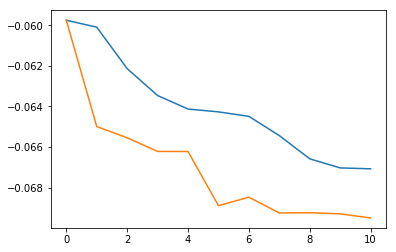

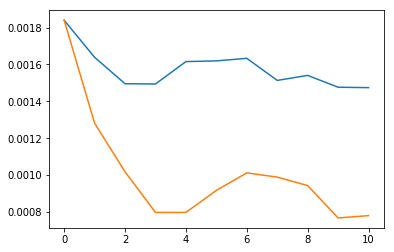

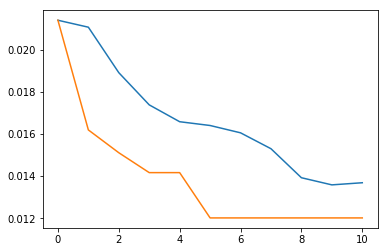

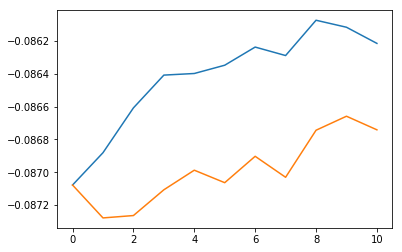

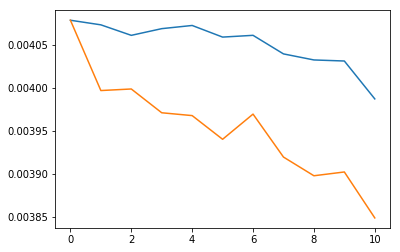

In [33]:
visualize_loss(loss)

In [34]:
def color(class_label, color_map): 
    return  {
    'fillOpacity': 0.5,
    'weight': 0.5,
    'fillColor': '#%02x%02x%02x' % tuple((256 * color_map[class_label,:3]).astype(int)),
    'color': '#%02x%02x%02x' % tuple((256 * color_map[class_label,:3]).astype(int))
     }   

def style_function(data):    
    if data['properties']['GMDNAME'] in series.index:
        class_label = series[series.index == data['properties']['GMDNAME']][0]
        return color(class_label, color_map)
    
    else:
        return  {
        'fillOpacity': 0.5,
        'weight': 0.5,
        'fillColor': '#%02x%02x%02x' % tuple((256 * color_map[0,:3]).astype(int)),
        'color': '#%02x%02x%02x' % tuple((256 * color_map[0,:3]).astype(int))
         } 
    
def map_cantons(series, json_data_gemeinden, json_data_kantone):
    center_coord = [46.8011111,8.2266667]
    cantons_map = folium.Map(location=center_coord,
                tiles='cartodbpositron',           
                zoom_start=7.5)

    scale = list(np.linspace(0.,series.max(),6))

    """
    cantons_map.choropleth(geo_data=json_data_gemeinden, topojson='objects.gemeinden', 
        data=series,
        key_on='feature.properties.GMDNAME',
        threshold_scale=scale,
        fill_color='YlOrRd', fill_opacity=0.6, line_opacity=0.3,
        highlight = True)
     
     """
    folium.TopoJson(json_data_gemeinden,'objects.gemeinden',name='gemeiden',
                    style_function=style_function).add_to(cantons_map)

    folium.TopoJson(json_data_kantone,'objects.kantone',name='cantons',style_function=lambda feature: {
            'color': 'blue',
            'fillOpacity':0.0,
            'weight': 2}).add_to(cantons_map)
    
    return cantons_map


#display a map to see a first estimation of the results

json_data_gemeinden = json.load(codecs.open('data/gemeinden.topo.json', 'r', 'utf-8-sig'))
json_data_kantone = json.load(codecs.open('data/kantone.topo.json', 'r', 'utf-8-sig'))

cmap = matplotlib.cm.get_cmap('Spectral')
color_map = cmap(np.arange(0,1,1/26))

series=pd.Series(out[0],index=data2.index.values)
m_swiss = map_cantons(series, json_data_gemeinden, json_data_kantone)

m_swiss

### Treat the different results
We handle the different results obtained with the genetic algorithm

In [35]:
#generate a 
shuffle = np.arange(26) 
np.random.shuffle(shuffle)
np.save('shuffle.npy',shuffle)

In [36]:
#add commune and canton data to the raw results
def transform_map(input_file,output_file,original):
    label = np.load(input_file)
    
    pop = general['voters']
    pop = pop.reset_index()
    
    most_pop_name=[]
    
    
    shuffle = np.load('shuffle.npy')
    name = general.index.values
    
    if original:
        most_pop_name = ['Zürich','Bern','Luzern','Uri','Schwyz','Obwalden','Nidwalden','Glarus','Zug','Fribourg','Solothurn','Basel-Stadt','Basel-Landschaft','Schaffhausen','Appenzell Ausserrhoden','Appenzell Innerrhoden','St. Gallen','Graubünden','Aargau','Thurgau','Ticino','Vaud','Valais','Neuchâtel','Geneva','Jura']
    else:
        for i in np.arange(26):
            name_list = pop[label==i]['voters']
                             
            if name_list.empty:
                most_pop_name.append('None')
            else:
                most_pop_name.append(name[name_list.argmax()])

    
    label = shuffle[label]
    
    fd = most_pop_name.copy()
    
    for i,s in enumerate(shuffle):
        most_pop_name[s] = fd[i]
    
    data_other = pd.DataFrame([name,label])
    data_other = data_other.transpose()

    data_other['Canton_name']=[most_pop_name[l] for l in label]    

    data_other.columns=['Name','Label','Canton_name']

    data_other.to_csv(output_file,index=False)

In [37]:
transform_map('results/original_cantons.npy','results/original_cantons.csv',True)
transform_map('results/best_result_loss_all.npy','results/representativity_optimized_constrained.csv',False)
transform_map('results/best_result_loss_only_data.npy','results/representativity_optimized_unconstrained.csv',False)
transform_map('results/best_result_random_2.npy','results/representativity_optimized_random.csv',False)
transform_map('results/best_result_gerry_0.npy','results/party_0_optimized.csv',False)
transform_map('results/best_result_gerry_1.npy','results/party_1_optimized.csv',False)
transform_map('results/best_result_gerry_2.npy','results/party_2_optimized.csv',False)
transform_map('results/best_result_gerry_3.npy','results/party_3_optimized.csv',False)
transform_map('results/best_result_gerry_4.npy','results/party_4_optimized.csv',False)
transform_map('results/best_result_gerry_5.npy','results/party_5_optimized.csv',False)
transform_map('results/best_result_gerry_6.npy','results/party_6_optimized.csv',False)
transform_map('results/best_result_gerry_7.npy','results/party_7_optimized.csv',False)
transform_map('results/best_result_gerry_8.npy','results/party_8_optimized.csv',False)
transform_map('results/best_result_gerry_9.npy','results/party_9_optimized.csv',False)
transform_map('results/best_result_gerry_10.npy','results/party_10_optimized.csv',False)
transform_map('results/best_result_gerry_11.npy','results/party_11_optimized.csv',False)
transform_map('results/best_result_gerry_12.npy','results/party_12_optimized.csv',False)
transform_map('results/best_result_gerry_13.npy','results/party_13_optimized.csv',False)
transform_map('results/best_result_gerry_14.npy','results/party_14_optimized.csv',False)

/home/samuel/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:23: FutureWarning: 'argmax' is deprecated. Use 'idxmax' instead. The behavior of 'argmax' will be corrected to return the positional maximum in the future. Use 'series.values.argmax' to get the position of the maximum now.


In [48]:
#merge all the gerrymandering results in one file
party = ['BDP/PBD','CSP/PCS','CVP/PDC','EVP/PEV','FDP/PLR (PRD)','GLP/PVL','PdA/PST','SP/PS','SVP/UDC','EDU/UDF','GPS/PES','Lega','MCR','SD/DS','Sol.']

data_new=pd.read_csv('results/party_0_optimized.csv')


data_other=data_new['Name'].to_frame()

for i,p in enumerate(party):
    filename = 'results/party_'+str(i)+'_optimized.csv'
    data_new=pd.read_csv(filename)
    data_other[p]=data_new['Label']

data_other.to_csv('results/full_gerry_map.csv',index=False)

party = ['BDP/PBD','CSP/PCS','CVP/PDC','EVP/PEV','FDP/PLR (PRD)','GLP/PVL','PdA/PST','SP/PS','SVP/UDC','EDU/UDF','GPS/PES','Lega','MCR','SD/DS','Sol.']

data_new=pd.read_csv('results/party_0_optimized.csv')


data_other=data_new['Name'].to_frame()

for i,p in enumerate(party):
    filename = 'results/party_'+str(i)+'_optimized.csv'
    data_new=pd.read_csv(filename)
    data_other[p]=data_new['Canton_name']

data_other.to_csv('results/full_gerry_names.csv',index=False)


In [50]:
#remove the urne commune in the different commune names
data_other = pd.read_csv('results/original_cantons.csv')
data_other['Name']=data_other['Name'].str.replace(re.escape(' (Urne commune)'),'')
data_other.to_csv('results/original_cantons.csv',index=False)

data_other = pd.read_csv('results/representativity_optimized_unconstrained.csv')
data_other['Name']=data_other['Name'].str.replace(re.escape(' (Urne commune)'),'')
data_other.to_csv('results/representativity_optimized_unconstrained.csv',index=False)

data_other = pd.read_csv('results/representativity_optimized_constrained.csv')
data_other['Name']=data_other['Name'].str.replace(re.escape(' (Urne commune)'),'')
data_other.to_csv('results/representativity_optimized_constrained.csv',index=False)

data_other = pd.read_csv('results/representativity_optimized_random.csv')
data_other['Name']=data_other['Name'].str.replace(re.escape(' (Urne commune)'),'')
data_other.to_csv('results/representativity_optimized_random.csv',index=False)

data_other = pd.read_csv('results/full_gerry_map.csv')
data_other['Name']=data_other['Name'].str.replace(re.escape(' (Urne commune)'),'')
data_other.to_csv('results/full_gerry_map.csv',index=False)

data_other = pd.read_csv('results/full_gerry_names.csv')
data_other['Name']=data_other['Name'].str.replace(re.escape(' (Urne commune)'),'')
data_other.to_csv('results/full_gerry_names.csv',index=False)

### Generate the JSON files for parliament
Since we want to display the parliament in our website, we must generate JSON files accordingly

In [51]:
def rearrange(target_list, order):
    return [ target_list[i] for i in order]

def generate_parliament_json(file_name, ids, seats, order):
    names = ['Conservative Democratic Party',
        'Christian Social Party',
        'Christian Democratic People\'s Party',
        'Evangelical People\'s Party',
        'The Liberals',
        'Green Liberal Party',
        'Swiss Party of Labour',
        'Social Democratic Party',
        'Swiss People\'s Party',
        'Federal Democratic Union',
        'Green Party',
        'Ticino League',
        'Romandy Citizens\' Movement',
        'Swiss Democrats',
        'solidaritéS',
        'Others']

    ids = rearrange(ids,order)
    seats = rearrange(seats,order)
    names = rearrange(names,order)
    
    d = {'id': ids, 
         'legend' : names,
         'name' : names,
         'seats': seats}
    
    parliament = pd.DataFrame(data=d)

    with open('data/' + file_name +'.json', 'w') as outfile:
        json.dump(json.JSONDecoder().decode(parliament.to_json(orient='records')), outfile, ensure_ascii=False)
        

def generate_national_parliament(input_file,output_file,data_tab,pop,party_names,l_to_r):
    vote_data = np.squeeze(data_tab.transpose())
    data_in = pd.read_csv(input_file)
    label = np.squeeze(np.array(data_in['Label'].astype(int)))
    vote_per_canton = aggregate_canton(vote_data,pop,label,26)
    number_elected_tab = distribute_sieges(pop,label,26,200)
    elected = compute_election(vote_per_canton,number_elected_tab).sum(1)
    generate_parliament_json(output_file, party_names, elected, l_to_r)
    
def generate_states_parliament(input_file,output_file,data_tab,pop,party_names,l_to_r):
    vote_data = np.squeeze(data_tab.transpose())
    data_in = pd.read_csv(input_file)
    label = np.squeeze(np.array(data_in['Label'].astype(int)))
    vote_per_canton = aggregate_canton(vote_data,pop,label,26)
    number_elected_tab = 2 * np.ones(26)
    elected = compute_election(vote_per_canton,number_elected_tab).sum(1)
    generate_parliament_json(output_file, party_names, elected, l_to_r)

In [52]:
# arrange seats from most progressive to most conservative
left_to_right = [6,14,10,1,7,13,3,5,2,4,0,8,13,12,11,15]

# national council
real_seats = [7,0,28,2,33,7,1,43,65,0,11,2,0,0,0,1]
generate_parliament_json('parliament_2015_national',data2.columns.values,real_seats,left_to_right)

# council of states
real_seats = [1,0,13,0,13,0,0,12,5,0,1,0,0,0,0,1]
generate_parliament_json('parliament_2015_states',data2.columns.values,real_seats,left_to_right)

data2=data.drop([col for col, val in data.sum().iteritems() if val==0],axis=1)
features = pd.DataFrame(data2)
party_names = features.columns.values
party_names[4] = 'FDP/PLR'

generate_national_parliament('results/original_cantons.csv','parliament_simulate_original_national',data_tab,pop_tab,party_names,left_to_right)
generate_states_parliament('results/original_cantons.csv','parliament_simulate_original_states',data_tab,pop_tab,party_names,left_to_right)

generate_national_parliament('results/representativity_optimized_unconstrained.csv','parliament_simulate_unconstrained_national',data_tab,pop_tab,party_names,left_to_right)
generate_states_parliament('results/representativity_optimized_unconstrained.csv','parliament_simulate_unconstrained_states',data_tab,pop_tab,party_names,left_to_right)

generate_national_parliament('results/representativity_optimized_constrained.csv','parliament_simulate_constrained_national',data_tab,pop_tab,party_names,left_to_right)
generate_states_parliament('results/representativity_optimized_constrained.csv','parliament_simulate_constrained_states',data_tab,pop_tab,party_names,left_to_right)

generate_national_parliament('results/representativity_optimized_random.csv','parliament_simulate_random_national',data_tab,pop_tab,party_names,left_to_right)
generate_states_parliament('results/representativity_optimized_random.csv','parliament_simulate_random_states',data_tab,pop_tab,party_names,left_to_right)

/home/samuel/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:33: RuntimeWarning: invalid value encountered in true_divide
/home/samuel/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:45: RuntimeWarning: invalid value encountered in greater


In [53]:
A=np.squeeze(data_tab.transpose())
B=np.squeeze(pop_tab)
C=26
E=200
E2=2

H=compute_national_vote(A,B)


def rearrange(target_list, order):
    return [ target_list[i] for i in order]


left_to_right = [6,14,10,1,7,3,5,2,4,0,8,9,13,12,11,15]

file = pd.read_csv('results/full_gerry_map.csv')


data2=data.drop([col for col, val in data.sum().iteritems() if val==0],axis=1)
features = pd.DataFrame(data2)
party_names = features.columns.values
party_names2 = party_names.copy()
party_names2[4] = 'FDP/PLR'

names = ['Conservative Democratic Party',
'Christian Social Party',
'Christian Democratic People\'s Party',
'Evangelical People\'s Party',
'The Liberals',
'Green Liberal Party',
'Swiss Party of Labour',
'Social Democratic Party',
'Swiss People\'s Party',
'Federal Democratic Union',
'Green Party',
'Ticino League',
'Romandy Citizens\' Movement',
'Swiss Democrats',
'solidaritéS',
'Others']

ids = rearrange(party_names2,left_to_right)
names = rearrange(names,left_to_right)



name_list=[]

seats_national_list = []
seats_states_list = []
  

for elem in party_names[:-1]:
    label = np.array(file[elem])
    D=np.squeeze(label)

    M=aggregate_canton(A,B,D,C)

    F=distribute_sieges(B,D,C,E)
    G=compute_election(M,F)
    seats_national = G.sum(1)
    G=compute_election(M,E2 * np.ones(C))
    seats_states=G.sum(1)
 
    seats_national = rearrange(seats_national.tolist(),left_to_right)
    seats_states = rearrange(seats_states.tolist(),left_to_right)
    
    seats_national = [int(i) for i in seats_national]
    seats_states = [int(i) for i in seats_states]
    
    d_national = []
    d_states = []
    
    for i,elem_name in enumerate(names):

        d_national.append({'id': ids[i], 
                           'legend' : elem_name,
                           'name' : elem_name,
                           'seats': seats_national[i]})



        d_states.append({'id': ids[i], 
                         'legend' : elem_name,
                         'name' : elem_name,
                         'seats': seats_states[i]})
        
    name_list.append(elem)
    seats_national_list.append(d_national)
    seats_states_list.append(d_states)


final = {
    'optimized_for':name_list,
    'national_parliament':seats_national_list,
    'states_parliament':seats_states_list}

with open('data/' + 'gerry_parliaments' +'.json', 'w') as outfile:
    json.dump(final, outfile, ensure_ascii=False)

/home/samuel/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:33: RuntimeWarning: invalid value encountered in true_divide
/home/samuel/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:45: RuntimeWarning: invalid value encountered in greater


### Generate statistics for barplot
We need statistics to compare the different losses obtained with different cantons' distributions

In [57]:
A=np.squeeze(data_tab.transpose())
B=np.squeeze(pop_tab)
C=26
E=200
E2=2

H=compute_national_vote(A,B)

national_error=[]
states_error=[]
total_error=[]


print('original distribution')

distribution = np.array(pd.read_csv('results/original_cantons.csv')['Label'])
D=np.squeeze(distribution)

M=aggregate_canton(A,B,D,C)

F=distribute_sieges(B,D,C,E)
G=compute_election(M,F)
I=compute_elected_percentage(G,F)
J1=compute_representativity(I,H)

print(J1)
national_error.append(J1)

F=E2*np.ones(C)
G=compute_election(M,F)
I=compute_elected_percentage(G,F)
J2=compute_representativity(I,H)

print(J2)
states_error.append(J2)

print(J1+J2)
total_error.append(J1+J2)

print('theorical')

J1=np.square(np.round(H*E)/E - H).sum()

print(J1)
national_error.append(J1)

J2=np.square(np.round(H*(C*E2))/(C*E2) - H).sum()

print(J2)
states_error.append(J2)

print(J1 + J2)
total_error.append(J1+J2)

print('random')

distribution = [np.random.randint(C,size=distribution.shape[0]) for i in range(10)]
D=[np.squeeze(i) for i in distribution]

M=[aggregate_canton(A,B,elem,C) for elem in D]

F=[distribute_sieges(B,elem,C,E) for elem in D]
G=[compute_election(elem,F[i]) for i,elem in enumerate(M)]
I=[compute_elected_percentage(elem,F[i]) for i,elem in enumerate(G)]
J1=[compute_representativity(I,H) for elem in I]

print(np.array(J1).mean())
national_error.append(np.array(J1).mean())

F=E2*np.ones(C)
G=[compute_election(elem,F) for elem in M]
I=[compute_elected_percentage(elem,F) for elem in G]
J2=[compute_representativity(elem,H) for elem in I]

print(np.array(J2).mean())
states_error.append(np.array(J2).mean())

print(np.array(J1).mean()+np.array(J2).mean())
total_error.append(np.array(J1).mean()+np.array(J2).mean())

print('optmized - unconstrained')

distribution = np.array(pd.read_csv('results/representativity_optimized_unconstrained.csv')['Label'])
D=np.squeeze(distribution)

M=aggregate_canton(A,B,D,C)

F=distribute_sieges(B,D,C,E)
G=compute_election(M,F)
I=compute_elected_percentage(G,F)
J1=compute_representativity(I,H)

print(J1)
national_error.append(J1)

F=E2*np.ones(C)
G=compute_election(M,F)
I=compute_elected_percentage(G,F)
J2=compute_representativity(I,H)

print(J2)
states_error.append(J2)

print(J1+J2)
total_error.append(J1+J2)

print('optmized - constrained')

distribution = np.array(pd.read_csv('results/representativity_optimized_constrained.csv')['Label'])
D=np.squeeze(distribution)

M=aggregate_canton(A,B,D,C)

F=distribute_sieges(B,D,C,E)
G=compute_election(M,F)
I=compute_elected_percentage(G,F)
J1=compute_representativity(I,H)

print(J1)
national_error.append(J1)

F=E2*np.ones(C)
G=compute_election(M,F)
I=compute_elected_percentage(G,F)
J2=compute_representativity(I,H)

print(J2)
states_error.append(J2)

print(J1+J2)
total_error.append(J1+J2)

print('optmized - random')

distribution = np.array(pd.read_csv('results/representativity_optimized_random.csv')['Label'])
D=np.squeeze(distribution)

M=aggregate_canton(A,B,D,C)

F=distribute_sieges(B,D,C,E)
G=compute_election(M,F)
I=compute_elected_percentage(G,F)
J1=compute_representativity(I,H)

print(J1)
national_error.append(J1)

F=E2*np.ones(C)
G=compute_election(M,F)
I=compute_elected_percentage(G,F)
J2=compute_representativity(I,H)

print(J2)
states_error.append(J2)

print(J1+J2)
total_error.append(J1+J2)

print('for real')
real_seats = np.array([7,0,28,2,33,7,1,43,65,0,11,2,0,0,0,1])
I=real_seats/real_seats.sum()
J1=compute_representativity(I,H)

print(J1)
national_error.append(J1)

real_seats = np.array([1,0,13,0,13,0,0,12,5,0,1,0,0,0,0,1])
I=real_seats/real_seats.sum()
J2=compute_representativity(I,H)

print(J2)
states_error.append(J2)

print(J1 + J2)
total_error.append(J1+J2)

statistics = np.array([np.array(national_error),np.array(states_error),np.array(total_error)])
np.save('statistics.npy',statistics)

original distribution
0.00184021359157
0.021402576465
0.0232427900566
theorical
2.75193979978e-05
0.000464338597974
0.000491857995972
random
0.0662093562391
0.0835300541456
0.149739410385
optmized - unconstrained
9.92973080572e-05
0.00460550023816
0.00470479754622
optmized - constrained
0.000407897514482
0.00614462378634
0.00655252130082
optmized - random
0.00044601804934
0.00844698436445
0.00889300241379
for real
0.00319430230901
0.0870080890365
0.0902023913455


/home/samuel/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:33: RuntimeWarning: invalid value encountered in true_divide
/home/samuel/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:45: RuntimeWarning: invalid value encountered in greater
